<a href="https://colab.research.google.com/github/kollerbud/resume-rec/blob/main/Project_final_report_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from collections import Counter

In [ ]:
# Step 1: Load Datasets
# Load Resume Dataset
resume_df = pd.read_csv('Resume.csv')
resume_df = resume_df.rename(columns={'Resume_str': 'Resume'})
resume_df = resume_df.drop_duplicates(subset=['Resume'])  # Remove duplicates
resume_df = resume_df.dropna(subset=['Resume'])  # Drop rows with missing resumes
resume_df = resume_df.drop(columns=['Resume_html'])  # Drop unused column


In [ ]:
# Load LinkedIn Job Postings Dataset
job_df = pd.read_csv('postings.csv')

In [ ]:
# Load Additional Job and Company Data
job_jobskills = pd.read_csv('job_skills.csv').drop_duplicates(subset="job_id")
job_jobindustries = pd.read_csv('job_industries.csv').drop_duplicates(subset="job_id")
job_specialties = pd.read_csv('company_specialities.csv').drop_duplicates(subset="company_id")
job_industries = pd.read_csv('company_industries.csv').drop_duplicates(subset="company_id")
job_companies = pd.read_csv('companies.csv').drop_duplicates(subset="company_id")
job_skillsmapping = pd.read_csv('skills.csv').drop_duplicates(subset="skill_abr")
job_industrymapping = pd.read_csv('industries.csv').drop_duplicates(subset="industry_id")


In [ ]:
# Load Train and Test Data
train_resume = pd.read_csv('train_resume_id.csv')  # Train resume IDs
test_resume = pd.read_csv('test_resume_id.csv')    # Test resume IDs
test_jobs = pd.read_csv('testset_job_id.csv')      # Test job IDs

In [ ]:
# Merge Data
temp_df = job_df \
    .merge(job_jobskills, on="job_id", how="left") \
    .merge(job_jobindustries, on="job_id", how="left") \
    .merge(job_specialties, on="company_id", how="left") \
    .merge(job_industries, on="company_id", how="left") \
    .merge(job_companies, on="company_id", how="left") \
    .merge(job_skillsmapping, on="skill_abr", how="left") \
    .merge(job_industrymapping, on="industry_id", how="left")


In [ ]:
# Cleaning up temporary columns and renaming
temp_df['zip_code'] = temp_df['zip_code_x'].combine_first(temp_df['zip_code_y'])
temp_df = temp_df.rename(columns={'description_x': 'job_description', 'description_y': 'company_description'})
jobpost_df = temp_df.drop(columns=[
     'company_id', 'applies', 'original_listed_time', 'application_type', 'expiry',
    'closed_time', 'sponsored', 'fips', 'skill_abr', 'industry_id', 'zip_code_x', 'zip_code_y'
])


In [ ]:
# Step 2: Combine Relevant Fields
jobpost_df['concat_posting'] = jobpost_df['title'].fillna('') + " " + \
                               jobpost_df['job_description'].fillna('') + " " + \
                               jobpost_df['skills_desc'].fillna('') + " " + \
                               jobpost_df['skill_name'].fillna('') + " " + \
                               jobpost_df['industry_name'].fillna('')


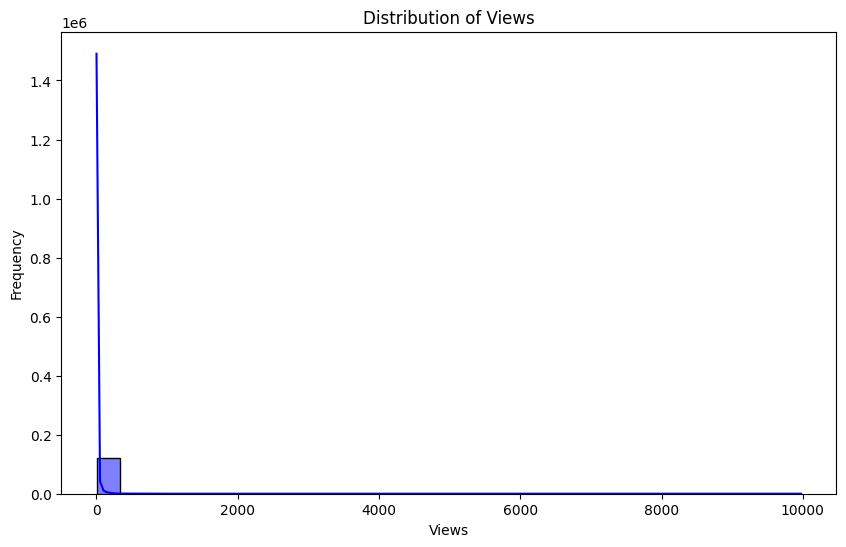

In [ ]:
# 2. Distribution of Views

import seaborn as sns # Import the seaborn library
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(jobpost_df['views'], bins=30, kde=True, color="blue")
plt.title("Distribution of Views")
plt.xlabel("Views")
plt.ylabel("Frequency")
plt.show()

<ipython-input-10-4f8f420aecf4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette="mako")


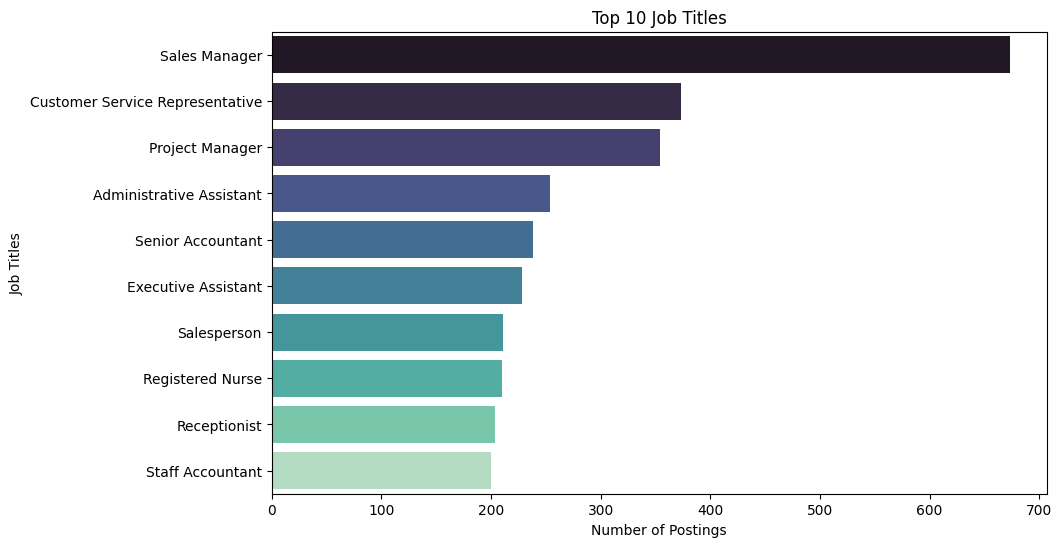

In [ ]:
top_job_titles = jobpost_df['title'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette="mako")
plt.title("Top 10 Job Titles")
plt.xlabel("Number of Postings")
plt.ylabel("Job Titles")
plt.show()

<ipython-input-11-ccb61305490e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="rocket")


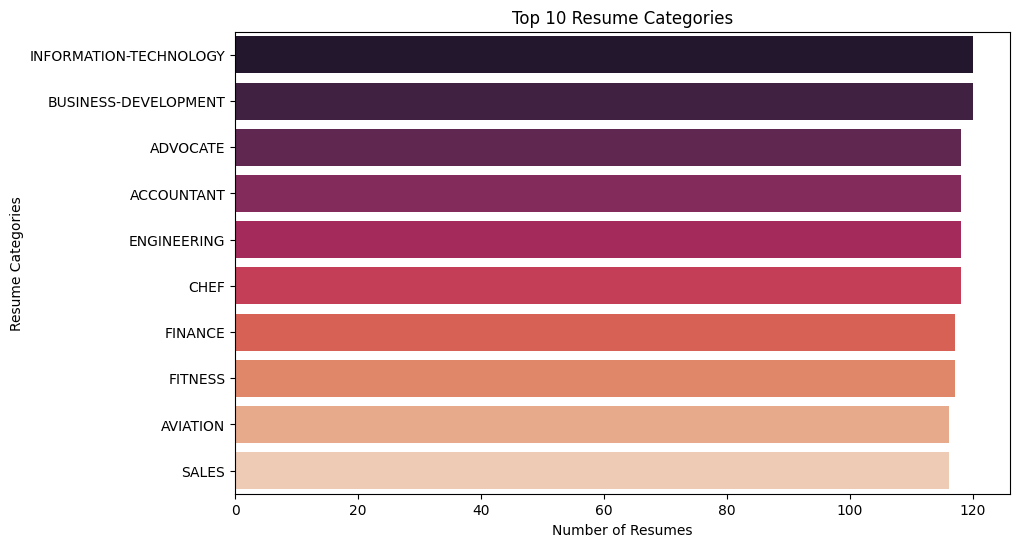

In [ ]:
top_categories = resume_df['Category'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="rocket")
plt.title("Top 10 Resume Categories")
plt.xlabel("Number of Resumes")
plt.ylabel("Resume Categories")
plt.show()

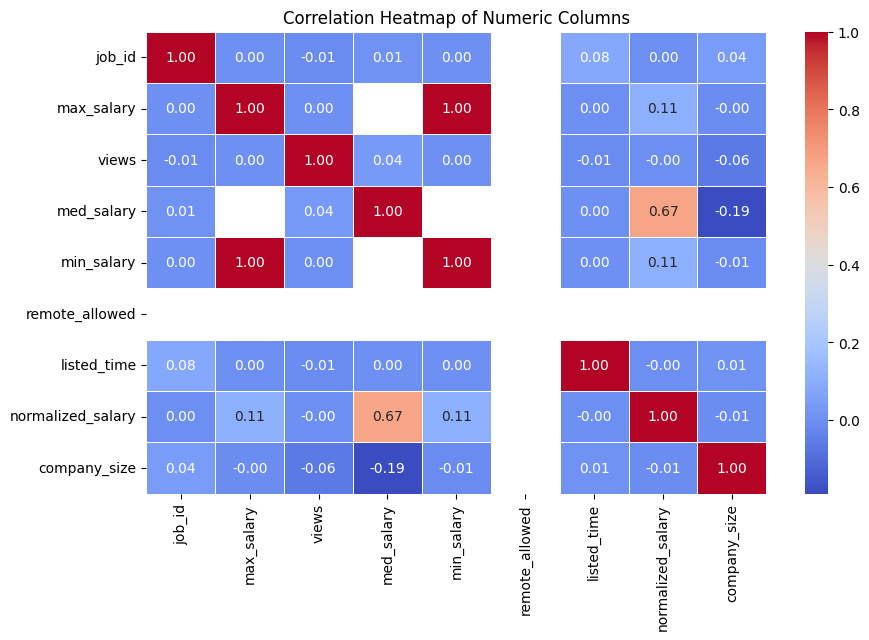

In [ ]:
# 5. Correlation Heatmap (for numeric fields)
numeric_columns = jobpost_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()


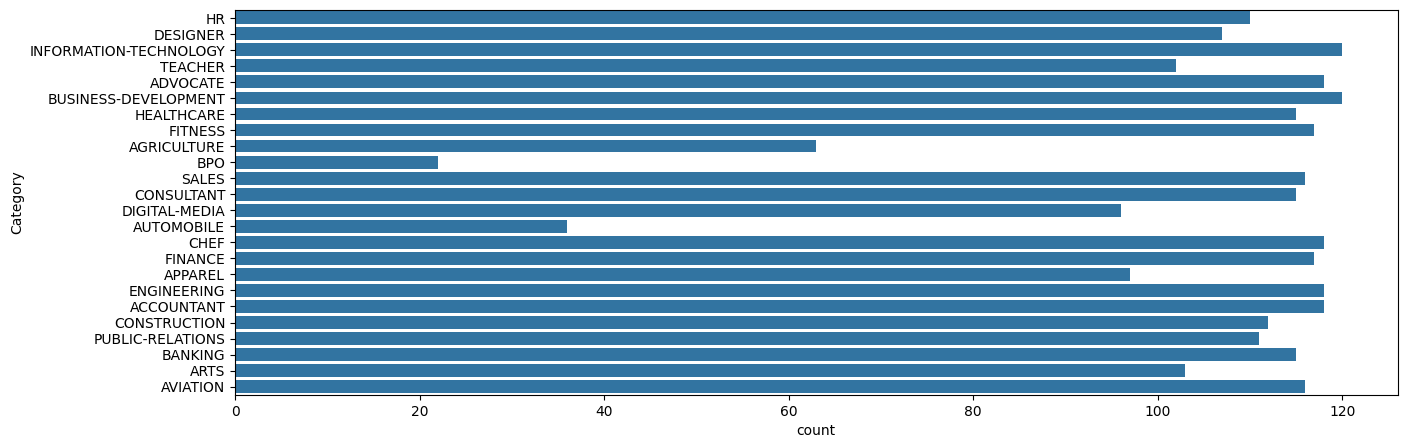

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(resume_df['Category'])
plt.show()

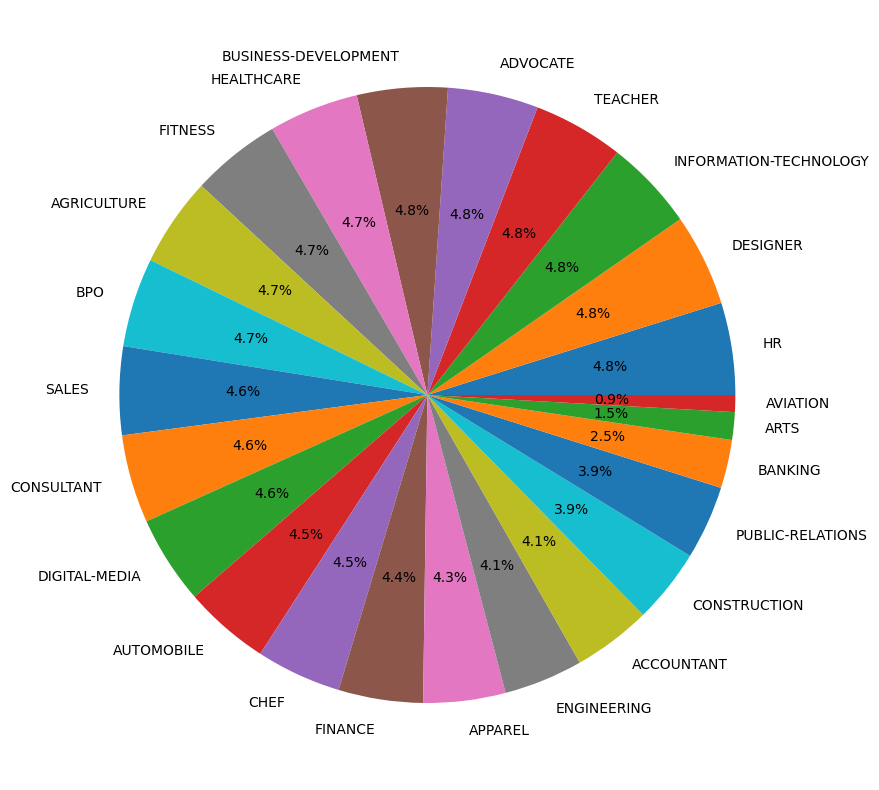

In [ ]:
counts = resume_df['Category'].value_counts()
labels = resume_df['Category'].unique()
plt.figure(figsize=(15,10))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

In [ ]:

# Step 3: Clean Text
def clean_text(txt):
    cleanText = re.sub('http\S+\s*', ' ', txt)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+', '', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', r' ', cleanText)
    cleanText = re.sub(r'\s+', ' ', cleanText)
    cleanText = re.sub(r'[^\w\s]', '', cleanText)
    cleanText = re.sub(r'[\r\n\t]', ' ', cleanText)
    cleanText = re.sub('ï»¿', '', cleanText)
    return cleanText.strip()

In [ ]:
# Apply Cleaning
resume_df['Resume'] = resume_df['Resume'].apply(clean_text)
jobpost_df['concat_posting'] = jobpost_df['concat_posting'].astype(str).apply(clean_text)



In [ ]:
print("Columns in jobpost_df:", jobpost_df.columns)



Columns in jobpost_df: Index(['job_id', 'company_name', 'title', 'job_description', 'max_salary',
       'pay_period', 'location', 'views', 'med_salary', 'min_salary',
       'formatted_work_type', 'remote_allowed', 'job_posting_url',
       'application_url', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'speciality', 'industry',
       'name', 'company_description', 'company_size', 'state', 'country',
       'city', 'address', 'url', 'skill_name', 'industry_name', 'zip_code',
       'concat_posting'],
      dtype='object')


In [ ]:
# Step 4: Filter Train and Test Data
train_resumes = resume_df[resume_df['ID'].isin(train_resume['ID'])]
test_resumes = resume_df[resume_df['ID'].isin(test_resume['ID'])]
test_job_postings = jobpost_df[jobpost_df['job_id'].isin(test_jobs['job_id'])]


In [ ]:
# Step 4: Tokenization
resume_tokens = resume_df['Resume'].apply(lambda x: x.split())
jobpost_tokens = jobpost_df['concat_posting'].apply(lambda x: x.split())


In [ ]:
# Step 5: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
job_tfidf_test = tfidf_vectorizer.fit_transform(test_job_postings['concat_posting'])
test_resume_tfidf = tfidf_vectorizer.transform(test_resumes['Resume'])




In [ ]:
# Step 6: Compute Euclidean Distance for Recommendations
euclidean_dist = euclidean_distances(test_resume_tfidf, job_tfidf_test)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Function to generate recommendations
def tfidf_recommender(euclidean_dist: np.ndarray,
                      job_data: pd.DataFrame,
                      resume_data: pd.DataFrame,
                      top_k: int = 1):
    """
    Generate recommendations using Euclidean distance.

    Parameters:
    - euclidean_dist: Precomputed Euclidean distance matrix
    - job_data: DataFrame containing job details
    - resume_data: DataFrame containing resume details
    - top_k: Number of top recommendations to extract for each resume

    Returns:
    - DataFrame of recommendations
    """
    # Find top_k closest jobs for each resume
    top_idx = np.argpartition(euclidean_dist, top_k, axis=1)[:, :top_k]
    top_distances = np.take_along_axis(euclidean_dist, top_idx, axis=1)

    # Extract relevant details for recommendations
    resume_ids = resume_data['ID'].tolist()
    resume_texts = resume_data['Resume'].tolist()
    job_ids = np.array(job_data['job_id'].tolist())[top_idx].flatten()
    job_titles = np.array(job_data['title'].tolist())[top_idx].flatten()
    companies = np.array(job_data['company_name'].tolist())[top_idx].flatten()
    job_descriptions = np.array(job_data['concat_posting'].tolist())[top_idx].flatten()
    distances = top_distances.flatten()

    # Create recommendations DataFrame
    recommendations_df = pd.DataFrame({
        'resume_idx': np.repeat(resume_ids, top_k),
        'resume_text': np.repeat(resume_texts, top_k),
        'job_idx': job_ids,
        'job_title': job_titles,
        'company': companies,
        'job_description': job_descriptions,
        'distance_score': distances
    })

    # Sort by distance score (ascending for Euclidean distance)
    return recommendations_df.sort_values('distance_score', ascending=True)

# Example Usage
# Assuming:
# - `euclidean_dist`: Computed Euclidean distances from Step 6
# - `test_job_postings`: DataFrame of test job postings
# - `test_resumes`: DataFrame of test resumes

top_k = 1  # Set the number of recommendations per resume
recommendations = tfidf_recommender(
    euclidean_dist=euclidean_dist,
    job_data=test_job_postings,
    resume_data=test_resumes,
    top_k=top_k
)

# Save recommendations to a CSV file
recommendations.to_csv('tfidf_recommendations.csv', index=False)

# Display the top recommendations
recommendations.head()


,resume_idx,resume_text,job_idx,job_title,company,job_description,distance_score
290,29775391,EX CUTIVE BANQUETTE SOUS CHEF Professional Sum...,3888938720,Cook,St. Gregory Recovery Center,Cook Cook St Gregory Recovery Center Bayard Io...,0.608766
277,14663897,CHEF Credentials National Registry of Food Saf...,3905367761,SOUS CHEF - STEAKHOUSE,Hard Rock Casino Cincinnati,SOUS CHEF STEAKHOUSE Overview The incumbent in...,0.612993
502,33627938,PERSONNEL SECURITY SPECIALIST Summary Dedicate...,3905304172,Program Security Representative (PSR) - TS Cle...,AMERICAN SYSTEMS,Program Security Representative PSR TS Clearan...,0.619470
407,39908485,PROJECT MANGER LEAD SUPER Professional Summary...,3904988047,Construction Project Manager,"ProTech Services Group, Inc.",Construction Project Manager ProTech Services ...,0.622543
405,19364677,FACILITIES DESIGN AND CONSTRUCTION PROJECT MAN...,3889112428,Construction Project Manager - Solar Field Opp...,Burns & McDonnell,Construction Project Manager Solar Field Oppor...,0.623114


In [ ]:
# Generate Recommendations
recommendations = []
for i in range(len(test_resumes)):
    similar_jobs = euclidean_dist[i].argsort()[:5]  # Get top 5 closest jobs
    recommendations.append(similar_jobs)



In [ ]:
recommendation_df = pd.DataFrame({
    'Resume_Index': range(len(test_resumes)),
    'Recommended_Job_Indices': recommendations
})



In [ ]:

# Save Recommendations
recommendation_df.to_csv('recommendations_euclidean.csv', index=False)

In [ ]:
# Step 7: Visualization
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()


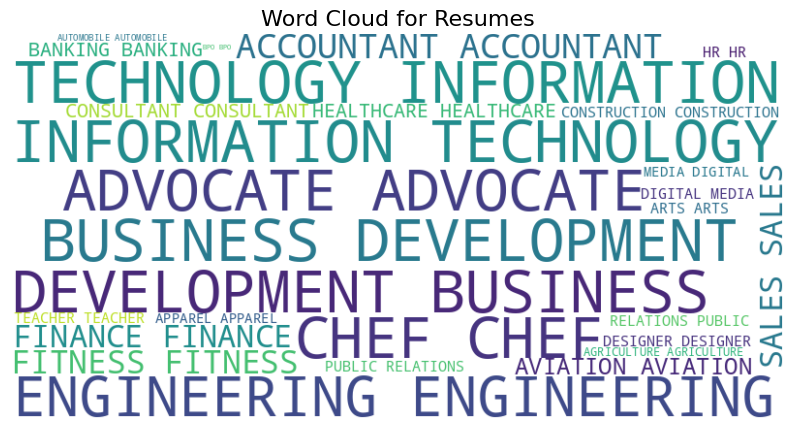

In [ ]:
# Word Clouds
plot_wordcloud(resume_df['Category'], "Word Cloud for Resumes")


In [ ]:
# Step 2: Extract top 200 recommendations per resume based on minimum distance
top_200_recommendations = []
for resume_index, distances in enumerate(euclidean_dist):
    # Get indices of top 200 smallest distances
    top_indices = np.argsort(distances)[:200]  # Smallest distances
    top_distances = distances[top_indices]

    # Store recommendations as (Resume ID, Job ID, Distance Score)
    recommendations = [
        (resume_index, job_index, distance) for job_index, distance in zip(top_indices, top_distances)
    ]
    top_200_recommendations.extend(recommendations)
